In [1]:
import pandas as pd
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
listings = pd.read_csv('./data/listings.csv', parse_dates=True)

In [4]:
listings.shape

(12029, 95)

In [5]:
listings.columns.sort_values()

Index(['access', 'accommodates', 'amenities', 'availability_30',
       'availability_365', 'availability_60', 'availability_90', 'bathrooms',
       'bed_type', 'bedrooms', 'beds', 'calculated_host_listings_count',
       'calendar_last_scraped', 'calendar_updated', 'cancellation_policy',
       'city', 'cleaning_fee', 'country', 'country_code', 'description',
       'experiences_offered', 'extra_people', 'first_review',
       'guests_included', 'has_availability', 'host_about',
       'host_acceptance_rate', 'host_has_profile_pic', 'host_id',
       'host_identity_verified', 'host_is_superhost', 'host_listings_count',
       'host_location', 'host_name', 'host_neighbourhood', 'host_picture_url',
       'host_response_rate', 'host_response_time', 'host_since',
       'host_thumbnail_url', 'host_total_listings_count', 'host_url',
       'host_verifications', 'house_rules', 'id', 'instant_bookable',
       'interaction', 'is_location_exact', 'jurisdiction_names', 'last_review',
       

The AirBNB listings dataframe has 95 columns of recorded values. The latitude/longitude values represent the location of the AirBNB listing. We  want to convert those values into geometrical points which can be represented using [shapely](http://toblerity.org/shapely/manual.html) and geopandas.

In [6]:
listings = gpd.GeoDataFrame(listings, geometry=listings.apply(
        lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'))

In [7]:
#listings[['geometry', 'neighbourhood_cleansed']]
listings.neighbourhood_cleansed.value_counts().head()

Waterfront Communities-The Island    1924
Niagara                               623
Church-Yonge Corridor                 484
Annex                                 454
Bay Street Corridor                   399
Name: neighbourhood_cleansed, dtype: int64

In [8]:
toronto = gpd.read_file('./data/neighbourhoods.geojson')

In [9]:
toronto['BNBs'] = toronto['neighbourhood'].map(listings['neighbourhood_cleansed'].value_counts())

In [10]:
#Determine the area of each neighbourhood in square km
toronto['area'] = toronto.geometry.to_crs({'init': 'epsg:3395'}).map(lambda p: p.area / 10**6)

In [11]:
toronto['BNBdensity'] = (toronto['BNBs'] / toronto['area']).fillna(0)

## Choropleths of AirBNB density by neighbourhood
- The same data is represented in both choropleths, but using different classification schemes
- The first choropleth groups the neighbourhoods into quantiles of the same size
- The second choropleth uses [Fisher-Jenks classification scheme](http://pysal.readthedocs.io/en/latest/library/esda/mapclassify.html#pysal.esda.mapclassify.Fisher_Jenks) and tries to group the neighbourhoods by minimizing intra-group variability and maximizing inter-group variability. More [here](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization) 

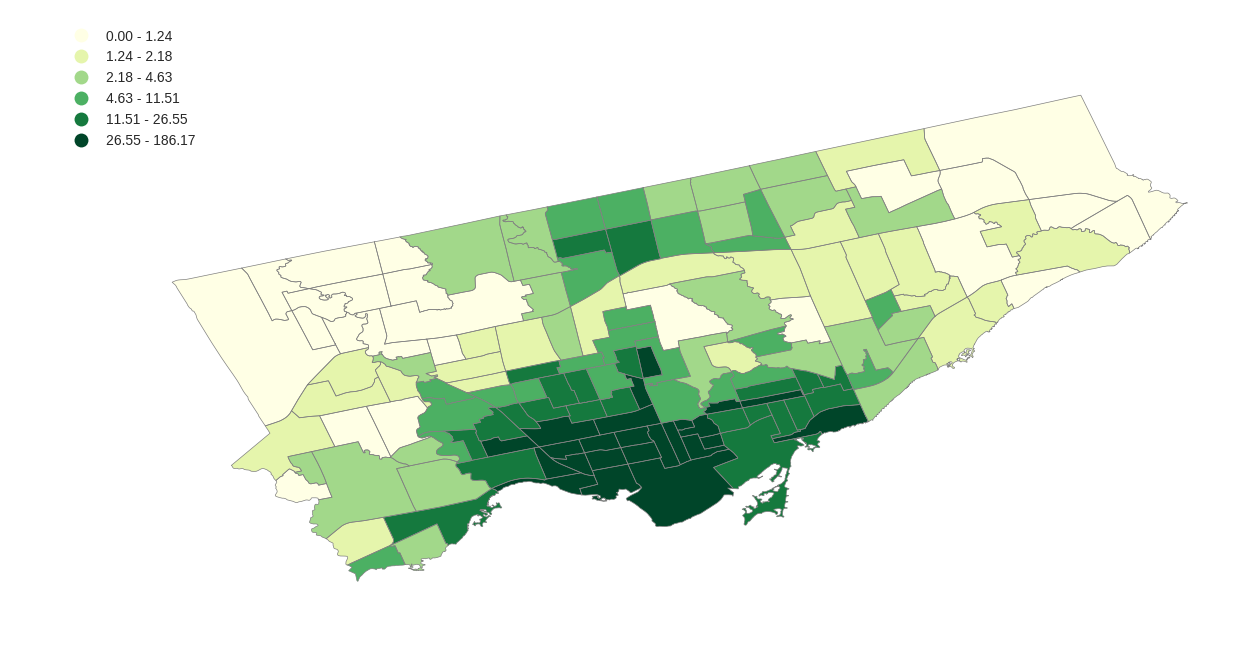

In [12]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()
kw = dict(column='BNBdensity', k=6, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
toronto.plot(scheme='quantiles', ax=ax, **kw)
ax.set_axis_off()

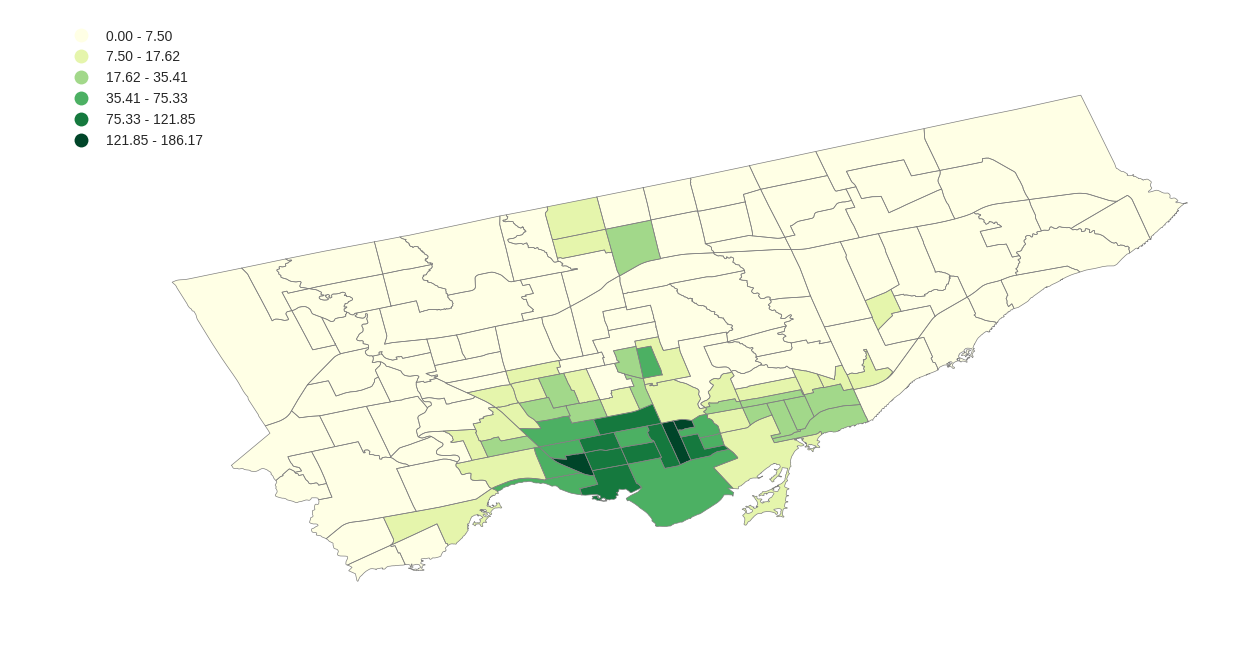

In [13]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()
kw = dict(column='BNBdensity', k=6, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
toronto.plot(scheme='fisher_jenks', ax=ax, **kw)
ax.set_axis_off()

## Understanding the classification schemes

In [14]:
def plot_scheme(scheme, var, df, figsize=(16, 8), saveto=None):
    '''
    Plot the distribution over value and geographical space of variable `var` using scheme `scheme
    ...
    
    Arguments
    ---------
    scheme   : str
               Name of the classification scheme to use 
    var      : str
               Variable name 
    df       : GeoDataFrame
               Table with input data
    figsize  : Tuple
               [Optional. Default = (16, 8)] Size of the figure to be created.
    saveto   : None/str
               [Optional. Default = None] Path for file to save the plot.
    '''
    from pysal.esda.mapclassify import Quantiles, Equal_Interval, Fisher_Jenks
    schemes = {'equal_interval': Equal_Interval, \
               'quantiles': Quantiles, \
               'fisher_jenks': Fisher_Jenks}
    classi = schemes[scheme](df[var], k=6)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    # KDE
    sns.kdeplot(df[var], shade=True, ax=ax1)
    sns.rugplot(df[var], alpha=0.5, ax=ax1)
    for cut in classi.bins:
        ax1.axvline(cut, color='red', linewidth=0.75)
    ax1.set_title('Value distribution')
    # Map
    p = df.plot(column=var, scheme=scheme, alpha=0.75, k=6, \
             colormap=plt.cm.YlGn, axes=ax2, linewidth=0.1)
    ax2.axis('equal')
    ax2.set_axis_off()
    ax2.set_title('Geographical distribution')
    f.suptitle(scheme, size=25)
    if saveto:
        plt.savefig(saveto)
    plt.show()

/home/derek/anaconda3/envs/geo3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/home/derek/anaconda3/envs/geo3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/home/derek/anaconda3/envs/geo3/lib/python3.5/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


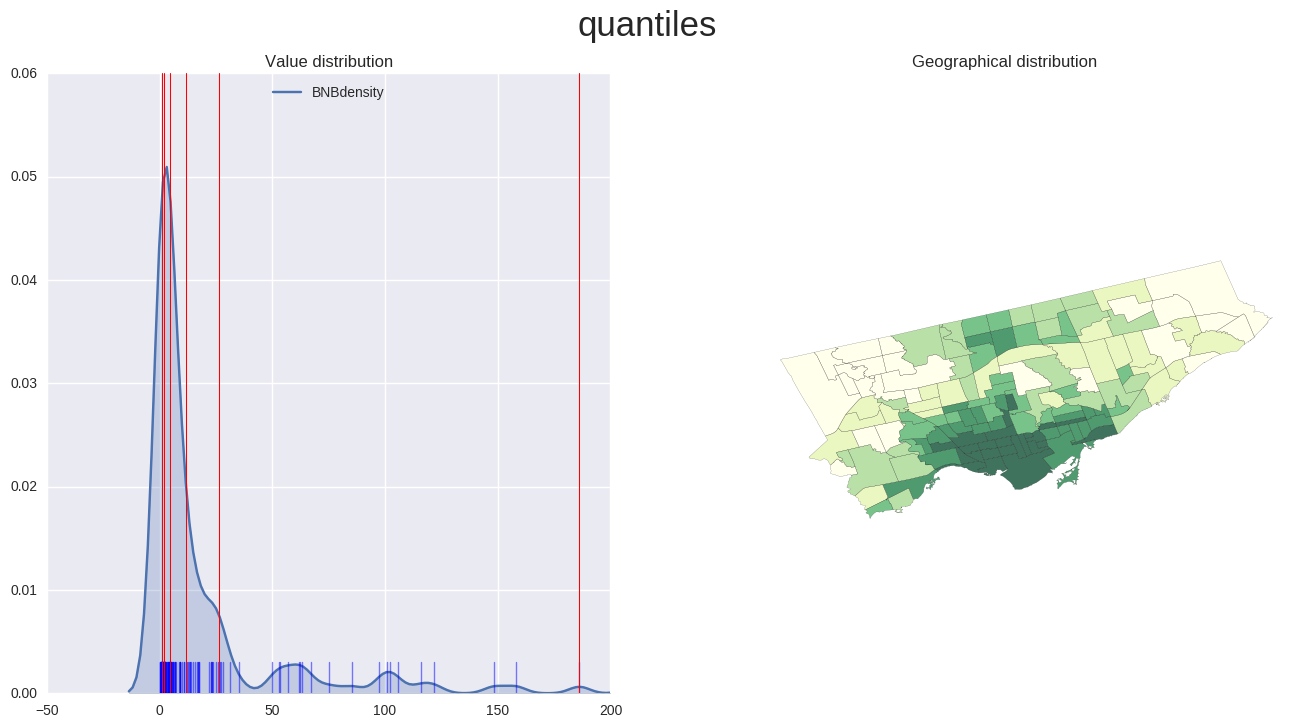

In [ ]:
plot_scheme('quantiles', 'BNBdensity', toronto)

In [ ]:
plot_scheme('fisher_jenks', 'BNBdensity', toronto)

/home/derek/anaconda3/envs/geo3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/home/derek/anaconda3/envs/geo3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/home/derek/anaconda3/envs/geo3/lib/python3.5/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)
